In [1]:
import fastf1 
import pandas as pd
import numpy as np

from fastf1 import get_session

import matplotlib.pyplot as plt
import seaborn as sns

fastf1.Cache.enable_cache('E:\School Stuff\F1cache')

In [ ]:
seasons = [2018, 2019, 2020, 2021, 2022, 2023, 2024]

In [ ]:
safety_car_laps = pd.DataFrame(columns=['Season', 'Track', 'VSCLaps', 'SCLaps', 'RedFlag'])

#for season in seasons:
#    schedule = pd.DataFrame(fastf1.get_event_schedule(season))
#    schedule = schedule[schedule['EventFormat'] != 'testing']
#    for index, event in schedule.iterrows():
#        race = event['Location']
#        session = fastf1.get_session(season, race, 'R')
#        session.load()
#        laps = pd.DataFrame(session.laps)
#        vsc_laps = laps[laps['TrackStatus'].str.contains('6|7')]['LapNumber'].unique()
#        sc_laps = laps[laps['TrackStatus'].str.contains('4')]['LapNumber'].unique()
#        red_flag = laps[laps['TrackStatus'].str.contains('5')]['LapNumber'].unique()
#        safety_car_laps.loc[len(safety_car_laps)] = [season, race, vsc_laps, sc_laps, red_flag]

In [ ]:
#session = fastf1.get_session(2024, 'Baku', 'R')
#session.load()
#laps = pd.DataFrame(session.laps)


In [ ]:
safety_car_laps = pd.read_csv('output.csv')

In [ ]:
season = 2024

schedule = pd.DataFrame(fastf1.get_event_schedule(season))
schedule = schedule[schedule['EventFormat'] != 'testing']
for index, event in schedule.iterrows():
    race = event['Location']
    session = fastf1.get_session(season, race, 'R')
    session.load()
    laps = pd.DataFrame(session.laps)
    vsc_laps = laps[laps['TrackStatus'].str.contains('6|7')]['LapNumber'].unique()
    sc_laps = laps[laps['TrackStatus'].str.contains('4')]['LapNumber'].unique()
    red_flag = laps[laps['TrackStatus'].str.contains('5')]['LapNumber'].unique()
    safety_car_laps.loc[len(safety_car_laps)] = [season, race, vsc_laps, sc_laps, red_flag]

In [ ]:
display(safety_car_laps)

In [ ]:
import ast

def parse_lap_string(lap_string):
    if isinstance(lap_string, list):
        return lap_string  # Already a list
    elif isinstance(lap_string, str):
        lap_string = lap_string.strip('[]')  # Remove brackets
        if lap_string == '':
            return []
        # Split on spaces, convert to floats
        return [float(x) for x in lap_string.split()]
    else:
        return []

for col in ['VSCLaps', 'SCLaps', 'RedFlag']:
    safety_car_laps[col] = safety_car_laps[col].apply(parse_lap_string)

In [ ]:
safety_car_laps['VSCLaps_count'] = safety_car_laps['VSCLaps'].apply(len)
safety_car_laps['SCLaps_count'] = safety_car_laps['SCLaps'].apply(len)
safety_car_laps['RedFlag_count'] = safety_car_laps['RedFlag'].apply(len)

In [ ]:
display(safety_car_laps)

In [ ]:
track_map = {
    'Marina Bay': 'Singapore',
    'Yas Island': 'Yas Marina',
    'Monte Carlo': 'Monaco'
}

safety_car_laps['Track'] = safety_car_laps['Track'].replace(track_map)
display(safety_car_laps)

In [ ]:
VSC_result = safety_car_laps.groupby('Track').agg(
    VSCLaps_sum=('VSCLaps_count', 'sum'),
    Track_count=('VSCLaps_count', 'size')
).reset_index()

VSC_result['AvgLapsPerRace'] = (VSC_result['VSCLaps_sum'] / VSC_result['Track_count'])

display(VSC_result)

In [ ]:
SC_result = safety_car_laps.groupby('Track').agg(
    SCLaps_sum=('SCLaps_count', 'sum'),
    Track_count=('SCLaps_count', 'size')
).reset_index()

SC_result['AvgLapsPerRace'] = (SC_result['SCLaps_sum'] / SC_result['Track_count'])
SC_result = SC_result.sort_values(
    by=['AvgLapsPerRace', 'Track_count'],
    ascending=[False, False]
).reset_index(drop=True)


#print(SC_result['Track_count'].sum())

display(SC_result)
SC_result.to_csv('sclaps_output.csv', index=False)

In [ ]:
RF_result = safety_car_laps.groupby('Track').agg(
    RedFlag_sum=('RedFlag_count', 'sum'),
    Track_count=('RedFlag_count', 'size')
).reset_index()

RF_result['AvgLapsPerRace'] = (RF_result['RedFlag_sum'] / RF_result['Track_count'])

display(RF_result)

In [2]:
session = get_session(2023, 'São Paulo', 'R')
session.load()

core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '14', '11', '18', '55', '10', '44', '22', '31', '2', '27', '3', '81', '63', '77', '24', '20', '23', '16']


In [4]:
telemetry_data = []

for drv in session.drivers:
    drv_code = session.get_driver(drv)['Abbreviation']
    laps = session.laps.pick_driver(drv_code)
    if laps.empty:
        continue

    for i, lap in laps.iterlaps():
        try:
            telemetry_lap = lap.get_telemetry()
            telemetry_lap['Driver'] = drv_code
            telemetry_lap['LapNumber'] = lap.LapNumber
            telemetry_lap = pd.merge_asof(
                telemetry_lap.sort_values('Time'),
                session.track_status[['Time', 'Status']].sort_values('Time'),
                on='Time',
                direction='backward'
            )
            telemetry_lap.rename(columns={'Status': 'TrackStatus'}, inplace=True)

            telemetry_data.append(telemetry_lap)
        except Exception as e:
            print(f"Skipping lap {lap.LapNumber} of {drv_code}: {e}")

# Combine all telemetry into a DataFrame
telemetry_all_df = pd.concat(telemetry_data, ignore_index=True)

C:\Users\jcf03\anaconda3\lib\site-packages\fastf1\core.py:3067: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
C:\Users\jcf03\anaconda3\lib\site-packages\fastf1\core.py:3067: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
C:\Users\jcf03\anaconda3\lib\site-packages\fastf1\core.py:3067: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
C:\Users\jcf03\anaconda3\lib\site-packages\fastf1\core.py:3067: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
C:\Users\jcf03\anaconda3\lib\site-packages\fastf1\co

In [5]:
len(telemetry_all_df)

679762

In [6]:
telemetry_all_df.head()

,Date,SessionTime,DriverAhead,DistanceToDriverAhead,Time,RPM,Speed,nGear,Throttle,Brake,...,Source,Distance,RelativeDistance,Status_x,X,Y,Z,Driver,LapNumber,Status_y
0,2023-11-05 17:03:22.842,0 days 01:02:22.839000,,0.53,0 days 00:00:00,9950.099977,0.0,1,16.0,True,...,interpolation,-0.002370,-5.666405e-07,OnTrack,-3587.001064,-5616.992459,7777.000297,VER,1.0,1
1,2023-11-05 17:03:22.880,0 days 01:02:22.877000,,0.53,0 days 00:00:00.038000,9957.066667,0.0,1,16.0,True,...,pos,-0.002105,-5.033323e-07,OnTrack,-3587.000000,-5617.000000,7777.000000,VER,1.0,1
2,2023-11-05 17:03:22.956,0 days 01:02:22.953000,,0.53,0 days 00:00:00.114000,9971.000000,0.0,1,16.0,True,...,car,0.000000,0.000000e+00,OnTrack,-3586.996920,-5617.021806,7776.999144,VER,1.0,1
3,2023-11-05 17:03:23.080,0 days 01:02:23.077000,,0.53,0 days 00:00:00.238000,9984.433333,0.0,1,16.0,True,...,pos,0.007603,1.817553e-06,OnTrack,-3587.000000,-5617.000000,7777.000000,VER,1.0,1
4,2023-11-05 17:03:23.196,0 days 01:02:23.193000,3,0.53,0 days 00:00:00.354000,9997.000000,0.0,1,16.0,True,...,car,0.000000,0.000000e+00,OnTrack,-3587.030123,-5616.786733,7777.008373,VER,1.0,1


In [16]:
telemetry_data = []

for drv in session.drivers:
    drv_code = session.get_driver(drv)['Abbreviation']
    laps = session.laps.pick_driver(drv_code)
    if laps.empty:
        continue

    for i, lap in laps.iterlaps():
        try:
            telemetry_lap = lap.get_telemetry()
            telemetry_lap['Driver'] = drv_code
            telemetry_lap['LapNumber'] = lap.LapNumber
            telemetry_lap['TrackStatus'] = lap.TrackStatus  # ← single value, per lap

            telemetry_data.append(telemetry_lap)
        except Exception as e:
            print(f"Skipping lap {lap.LapNumber} of {drv_code}: {e}")

# Combine all telemetry into a DataFrame
telemetry_all_df = pd.concat(telemetry_data, ignore_index=True)

C:\Users\jcf03\anaconda3\lib\site-packages\fastf1\core.py:3067: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
C:\Users\jcf03\anaconda3\lib\site-packages\fastf1\core.py:3067: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
C:\Users\jcf03\anaconda3\lib\site-packages\fastf1\core.py:3067: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
C:\Users\jcf03\anaconda3\lib\site-packages\fastf1\core.py:3067: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
C:\Users\jcf03\anaconda3\lib\site-packages\fastf1\co

In [17]:
telemetry_all_df.head()

,Date,SessionTime,DriverAhead,DistanceToDriverAhead,Time,RPM,Speed,nGear,Throttle,Brake,...,Source,Distance,RelativeDistance,Status,X,Y,Z,Driver,LapNumber,TrackStatus
0,2023-11-05 17:03:22.842,0 days 01:02:22.839000,,0.53,0 days 00:00:00,9950.099977,0.0,1,16.0,True,...,interpolation,-0.002370,-5.666405e-07,OnTrack,-3587.001064,-5616.992459,7777.000297,VER,1.0,124
1,2023-11-05 17:03:22.880,0 days 01:02:22.877000,,0.53,0 days 00:00:00.038000,9957.066667,0.0,1,16.0,True,...,pos,-0.002105,-5.033323e-07,OnTrack,-3587.000000,-5617.000000,7777.000000,VER,1.0,124
2,2023-11-05 17:03:22.956,0 days 01:02:22.953000,,0.53,0 days 00:00:00.114000,9971.000000,0.0,1,16.0,True,...,car,0.000000,0.000000e+00,OnTrack,-3586.996920,-5617.021806,7776.999144,VER,1.0,124
3,2023-11-05 17:03:23.080,0 days 01:02:23.077000,,0.53,0 days 00:00:00.238000,9984.433333,0.0,1,16.0,True,...,pos,0.007603,1.817553e-06,OnTrack,-3587.000000,-5617.000000,7777.000000,VER,1.0,124
4,2023-11-05 17:03:23.196,0 days 01:02:23.193000,3,0.53,0 days 00:00:00.354000,9997.000000,0.0,1,16.0,True,...,car,0.000000,0.000000e+00,OnTrack,-3587.030123,-5616.786733,7777.008373,VER,1.0,124


In [19]:
telemetry_all_df['TrackStatus']

array(['124', '45', '1'], dtype=object)

In [35]:
telemetry_all_df.to_csv('telemetry_all_df_output.csv', index=False)

In [3]:
status_df = session.track_status[['Time', 'Status']].sort_values('Time').copy()

In [4]:
display(status_df)

,Time,Status
0,0 days 00:00:00,1
1,0 days 01:00:00.637000,2
2,0 days 01:00:13.856000,1
3,0 days 01:00:14.200000,2
4,0 days 01:00:46.199000,1
5,0 days 01:01:00.340000,2
6,0 days 01:01:15.230000,1
7,0 days 01:02:32.198000,2
8,0 days 01:02:50.182000,4
9,0 days 01:05:35.568000,5


In [32]:
telemetry_data_with_status = telemetry_all_df.copy()


# Make sure all time columns are timedelta
telemetry_data_with_status['Time'] = pd.to_timedelta(telemetry_data_with_status['Time'])
status_df['Time'] = pd.to_timedelta(status_df['Time'])
status_df['EndTime'] = pd.to_timedelta(status_df['EndTime'])

# Drop last row (no EndTime)
status_df = status_df.dropna(subset=['EndTime'])

# Create interval index
intervals = pd.IntervalIndex.from_arrays(
    status_df['Time'],
    status_df['EndTime'],
    closed='left'
)

# Labels (must match interval count)
status_labels = status_df['Status'].astype(int).values

# Get bin indices: make sure this returns integers
bin_indices = pd.cut(
    telemetry_data_with_status['Time'],
    bins=intervals,
    labels=False
)

# Map index to label safely
def safe_label(i):
    try:
        i = int(i)
        return status_labels[i] if 0 <= i < len(status_labels) else np.nan
    except Exception:
        return np.nan

telemetry_data_with_status['TrackStatus'] = [safe_label(i) for i in bin_indices]

# Fill any NaNs with default green flag (1)
telemetry_data_with_status['TrackStatus'] = telemetry_data_with_status['TrackStatus'].fillna(1).astype(int)


In [33]:
telemetry_data_with_status.head()

,Date,SessionTime,DriverAhead,DistanceToDriverAhead,Time,RPM,Speed,nGear,Throttle,Brake,...,Source,Distance,RelativeDistance,Status,X,Y,Z,Driver,LapNumber,TrackStatus
0,2023-11-05 17:03:22.842,0 days 01:02:22.839000,,0.53,0 days 00:00:00,9950.099977,0.0,1,16.0,True,...,interpolation,-0.002370,-5.666405e-07,OnTrack,-3587.001064,-5616.992459,7777.000297,VER,1.0,1
1,2023-11-05 17:03:22.880,0 days 01:02:22.877000,,0.53,0 days 00:00:00.038000,9957.066667,0.0,1,16.0,True,...,pos,-0.002105,-5.033323e-07,OnTrack,-3587.000000,-5617.000000,7777.000000,VER,1.0,1
2,2023-11-05 17:03:22.956,0 days 01:02:22.953000,,0.53,0 days 00:00:00.114000,9971.000000,0.0,1,16.0,True,...,car,0.000000,0.000000e+00,OnTrack,-3586.996920,-5617.021806,7776.999144,VER,1.0,1
3,2023-11-05 17:03:23.080,0 days 01:02:23.077000,,0.53,0 days 00:00:00.238000,9984.433333,0.0,1,16.0,True,...,pos,0.007603,1.817553e-06,OnTrack,-3587.000000,-5617.000000,7777.000000,VER,1.0,1
4,2023-11-05 17:03:23.196,0 days 01:02:23.193000,3,0.53,0 days 00:00:00.354000,9997.000000,0.0,1,16.0,True,...,car,0.000000,0.000000e+00,OnTrack,-3587.030123,-5616.786733,7777.008373,VER,1.0,1


In [34]:
telemetry_data_with_status.to_csv('telemetry_data_with_status_output.csv', index=False)

In [36]:
telemetry_data_with_status['SessionTime'].dtype

dtype('<m8[ns]')

In [46]:
telemetry_data_with_status.sort_values(by=['SessionTime'], ascending=True, inplace=True)
telemetry_data_with_status.head()

,Date,SessionTime,DriverAhead,DistanceToDriverAhead,Time,RPM,Speed,nGear,Throttle,Brake,...,Source,Distance,RelativeDistance,Status,X,Y,Z,Driver,LapNumber,TrackStatus
0,2023-11-05 17:03:22.842,0 days 01:02:22.839000,,0.53,0 days,9950.099977,0.0,1,16.000000,True,...,interpolation,-0.002370,-5.666405e-07,OnTrack,-3587.001064,-5616.992459,7777.000297,VER,1.0,1
559660,2023-11-05 17:03:22.842,0 days 01:02:22.839000,,0.53,0 days,9811.775037,0.0,1,21.000000,True,...,interpolation,0.013307,3.122227e-06,OnTrack,-3763.003043,-4921.005909,7756.000519,PIA,1.0,1
474081,2023-11-05 17:03:22.842,0 days 01:02:22.839000,,0.53,0 days,10380.725081,0.0,1,19.000000,True,...,interpolation,0.009421,2.207959e-06,OnTrack,-3783.003370,-4841.992457,7753.997888,HUL,1.0,1
661921,2023-11-05 17:03:22.842,0 days 01:02:22.839000,,0.53,0 days,10795.650135,0.0,1,27.000000,False,...,interpolation,0.007110,1.636011e-06,OnTrack,-3946.001387,-4139.990476,7742.999893,ZHO,1.0,1
677038,2023-11-05 17:03:22.842,0 days 01:02:22.839000,,0.53,0 days,10954.224985,0.0,1,22.475001,True,...,interpolation,0.007834,2.100093e-05,OnTrack,-3798.001064,-4778.988773,7752.998020,MAG,1.0,1


In [51]:
for idx, line in telemetry_data_with_status.iterrows():
    if line['SessionTime'] >= status_df['Time'].iloc[6] and line['SessionTime'] < status_df['Time'].iloc[7]:
        telemetry_data_with_status.at[idx, 'TrackStatus'] = status_df['Status'].iloc[6]
    elif line['SessionTime'] >= status_df['Time'].iloc[7] and line['SessionTime'] < status_df['Time'].iloc[8]:
        telemetry_data_with_status.at[idx, 'TrackStatus'] = status_df['Status'].iloc[7]
    elif line['SessionTime'] >= status_df['Time'].iloc[8] and line['SessionTime'] < status_df['Time'].iloc[9]:
        telemetry_data_with_status.at[idx, 'TrackStatus'] = status_df['Status'].iloc[8]
    elif line['SessionTime'] >= status_df['Time'].iloc[9] and line['SessionTime'] < status_df['Time'].iloc[10]:
        telemetry_data_with_status.at[idx, 'TrackStatus'] = status_df['Status'].iloc[9]
    elif line['SessionTime'] >= status_df['Time'].iloc[10]:
        telemetry_data_with_status.at[idx, 'TrackStatus'] = status_df['Status'].iloc[10]

In [52]:
telemetry_data_with_status.to_csv('telemetry_data_with_status_output.csv', index=False)

In [5]:
telemetry_data_with_status = pd.read_csv('telemetry_data_with_status_output.csv')

In [6]:
x_train = telemetry_data_with_status[["DistanceToDriverAhead", "RPM", "Speed", "nGear", "Throttle", "Brake"]]
x_train[["DistanceToDriverAhead", "RPM", "Speed", "nGear", "Throttle", "Brake"]] = x_train[["DistanceToDriverAhead", "RPM", "Speed", "nGear", "Throttle", "Brake"]].astype('float32')
x_train = x_train.dropna()
y_train = telemetry_data_with_status[["TrackStatus"]]
y_train['TrackStatus'] = y_train['TrackStatus'].astype('float32')
y_train = y_train.dropna()

common_indices = x_train.index.intersection(y_train.index)
xtrain = x_train.loc[common_indices]
ytrain = y_train.loc[common_indices]

y_train = y_train.values.ravel()



C:\Users\jcf03\AppData\Local\Temp\ipykernel_20748\1235546273.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[["DistanceToDriverAhead", "RPM", "Speed", "nGear", "Throttle", "Brake"]] = x_train[["DistanceToDriverAhead", "RPM", "Speed", "nGear", "Throttle", "Brake"]].astype('float32')
C:\Users\jcf03\AppData\Local\Temp\ipykernel_20748\1235546273.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['TrackStatus'] = y_train['TrackStatus'].astype('float32')


In [7]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, Ytrain, Ytest = train_test_split(
    xtrain, ytrain, test_size=0.2, random_state=42  # 20% test, fixed split
)

In [8]:
print(len(Ytrain))
print(len(Ytest))

512714
128179


In [9]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42, verbose=1)
model.fit(Xtrain, Ytrain)
predictions = model.predict(Xtest)

C:\Users\jcf03\AppData\Local\Temp\ipykernel_20748\3068396859.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(Xtrain, Ytrain)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.9s finished


In [10]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(Ytest, predictions))
print("\nClassification Report:\n", classification_report(Ytest, predictions))
print("\nConfusion Matrix:\n", confusion_matrix(Ytest, predictions))

Accuracy: 0.974129927679261

Classification Report:
               precision    recall  f1-score   support

         1.0       0.98      1.00      0.99    121190
         2.0       0.85      0.39      0.53       562
         4.0       0.82      0.65      0.72      4457
         5.0       0.82      0.55      0.66      1970

    accuracy                           0.97    128179
   macro avg       0.87      0.65      0.73    128179
weighted avg       0.97      0.97      0.97    128179


Confusion Matrix:
 [[120675     27    370    118]
 [   308    219     34      1]
 [  1447     11   2881    118]
 [   658      0    224   1088]]


In [102]:
feature_names = Xtrain.columns
importances = model.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False) 
print(feature_imp_df)

                 Feature  Gini Importance
0  DistanceToDriverAhead         0.271437
1                    RPM         0.233639
2                  Speed         0.226518
4               Throttle         0.140185
3                  nGear         0.113597
5                  Brake         0.014624


In [6]:
def add_derived_features(df):
    # Ensure time column is timedelta
    if not np.issubdtype(df['Time'].dtype, np.timedelta64):
        df['Time'] = pd.to_timedelta(df['Time'])

    # Sort by driver and time for correct diffing
    df = df.sort_values(by=['Driver', 'Time']).copy()

    # Group by driver to avoid crossing telemetry streams
    grouped = df.groupby('Driver')

    # Delta time (in seconds)
    df['delta_time'] = grouped['Time'].diff().dt.total_seconds()

    # Basic deltas
    df['delta_speed'] = grouped['Speed'].diff()
    df['delta_throttle'] = grouped['Throttle'].diff()
    df['delta_brake'] = grouped['Brake'].diff()
    df['delta_rpm'] = grouped['RPM'].diff()
    df['delta_gear'] = grouped['nGear'].diff()

    # Acceleration estimate (m/s²)
    df['acceleration'] = df['delta_speed'] / df['delta_time']

    # Relative motion to driver ahead
    df['delta_dist_to_ahead'] = grouped['DistanceToDriverAhead'].diff()
    df['relative_speed_to_ahead'] = df['delta_dist_to_ahead'] / df['delta_time']

    # Rolling stats (3-sample window; adjust if needed)
    df['brake_mean_3'] = grouped['Brake'].rolling(3, min_periods=1).mean().reset_index(level=0, drop=True)
    df['throttle_std_3'] = grouped['Throttle'].rolling(3, min_periods=1).std().reset_index(level=0, drop=True)
    df['rpm_std_3'] = grouped['RPM'].rolling(3, min_periods=1).std().reset_index(level=0, drop=True)

    # Spatial deltas if X, Y, Z are present
    if all(col in df.columns for col in ['X', 'Y']):
        df['delta_x'] = grouped['X'].diff()
        df['delta_y'] = grouped['Y'].diff()
        df['track_movement'] = np.sqrt(df['delta_x']**2 + df['delta_y']**2)  # crude movement magnitude

    # Past TrackStatus
    #df['TrackStatus_prev'] = grouped['TrackStatus'].shift(1)
    
    return df

In [15]:
new_features = add_derived_features(telemetry_data_with_status)

In [18]:
new_features.head()

,Date,SessionTime,DriverAhead,DistanceToDriverAhead,Time,RPM,Speed,nGear,Throttle,Brake,...,acceleration,delta_dist_to_ahead,relative_speed_to_ahead,brake_mean_3,throttle_std_3,rpm_std_3,delta_x,delta_y,track_movement,TrackStatus_prev
16,2023-11-05 17:03:22.842,0 days 01:02:22.839000,NaN,0.53,0 days 00:00:00,10317.650029,0.0,1,18.0,True,...,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
30,2023-11-05 17:03:22.880,0 days 01:02:22.877000,NaN,0.53,0 days 00:00:00.038000,10309.100000,0.0,1,18.0,True,...,0.0,0.0,0.0,1.000000,0.0,6.045783,0.120360,-0.013449,0.121109,1.0
47,2023-11-05 17:03:22.956,0 days 01:02:22.953000,NaN,0.53,0 days 00:00:00.114000,10292.000000,0.0,1,18.0,True,...,0.0,0.0,0.0,1.000000,0.0,13.060353,0.366146,-0.038887,0.368205,1.0
79,2023-11-05 17:03:23.080,0 days 01:02:23.077000,NaN,0.53,0 days 00:00:00.238000,10265.650000,0.0,1,18.0,True,...,0.0,0.0,0.0,1.000000,0.0,21.888486,0.633854,0.038887,0.635046,1.0
96,2023-11-05 17:03:23.196,0 days 01:02:23.193000,3.0,0.53,0 days 00:00:00.354000,10241.000000,0.0,1,18.0,False,...,0.0,0.0,0.0,0.666667,0.0,25.504722,0.084688,0.380318,0.389632,1.0


In [19]:
new_features.to_csv('new_features_output.csv', index=False)

In [21]:
sc_starts = pd.to_timedelta(status_df['Time'].iloc[8])
sc_window_open = sc_starts - pd.Timedelta(seconds=30)

for idx, line in new_features.iterrows():
    if pd.to_timedelta(line['SessionTime']) >= sc_window_open and pd.to_timedelta(line['SessionTime']) < sc_starts:
        new_features.at[idx, 'SCin30'] = 1
    else:
        new_features.at[idx, 'SCin30'] = 0

In [23]:
new_features.to_csv('new_features_output.csv', index=False)

In [2]:
new_features = pd.read_csv('new_features_output.csv')

C:\Users\jcf03\AppData\Local\Temp\ipykernel_20376\3134807600.py:1: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  new_features = pd.read_csv('new_features_output.csv')


In [3]:
new_features.columns

Index(['Date', 'SessionTime', 'DriverAhead', 'DistanceToDriverAhead', 'Time',
       'RPM', 'Speed', 'nGear', 'Throttle', 'Brake', 'DRS', 'Source',
       'Distance', 'RelativeDistance', 'Status', 'X', 'Y', 'Z', 'Driver',
       'LapNumber', 'TrackStatus', 'delta_time', 'delta_speed',
       'delta_throttle', 'delta_brake', 'delta_rpm', 'delta_gear',
       'acceleration', 'delta_dist_to_ahead', 'relative_speed_to_ahead',
       'brake_mean_3', 'throttle_std_3', 'rpm_std_3', 'delta_x', 'delta_y',
       'track_movement', 'TrackStatus_prev', 'SCin30'],
      dtype='object')

In [4]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

In [42]:
feature_cols = ['DistanceToDriverAhead', 'RPM', 'Speed', 'nGear', 'Throttle', 'Brake', 'X', 'Y', 'Z', 'delta_time',
                'delta_speed', 'delta_throttle', 'delta_brake', 'delta_rpm', 'delta_gear',
       'acceleration', 'delta_dist_to_ahead', 'relative_speed_to_ahead',
       'brake_mean_3', 'throttle_std_3', 'rpm_std_3', 'delta_x', 'delta_y', 'track_movement']

X = new_features[feature_cols]
X['delta_brake'] = pd.to_numeric(X['delta_brake'], errors='coerce')
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = new_features['SCin30']
common_indices = X.index.intersection(y.index)
X = X.loc[common_indices]
y = y.loc[common_indices]


X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

# Handle imbalance
scale = (y_train == 0).sum() / (y_train == 1).sum()

C:\Users\jcf03\AppData\Local\Temp\ipykernel_20376\2119214802.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['delta_brake'] = pd.to_numeric(X['delta_brake'], errors='coerce')


In [43]:
from imblearn.over_sampling import SMOTE

sm = SMOTE()
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

In [62]:
model = XGBClassifier(
    scale_pos_weight=scale,
    max_depth=8,
    n_estimators=1000,
    learning_rate=0.03,
    eval_metric='aucpr',
    subsample=0.8,
    colsample_bytree=0.8
)
#model.fit(X_train, y_train)
model.fit(X_resampled, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [69]:
from catboost import CatBoostClassifier

In [70]:
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    loss_function='Logloss',
    eval_metric='AUC',
    auto_class_weights='Balanced',  # 👈 handles class imbalance
    verbose=100
)

model.fit(X_train, y_train)

0:	total: 166ms	remaining: 2m 46s
100:	total: 3.46s	remaining: 30.8s
200:	total: 6.52s	remaining: 25.9s
300:	total: 9.55s	remaining: 22.2s
400:	total: 12.6s	remaining: 18.9s
500:	total: 15.5s	remaining: 15.4s
600:	total: 18.3s	remaining: 12.1s
700:	total: 21.6s	remaining: 9.19s
800:	total: 24.8s	remaining: 6.15s
900:	total: 27.8s	remaining: 3.05s
999:	total: 30.7s	remaining: 0us


In [71]:
# Predict class labels (0 or 1)
y_pred = model.predict(X_test)

# Predict class probabilities
y_proba = model.predict_proba(X_test)[:, 1]  # probability of class 1

In [72]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.997340509735634
ROC AUC: 0.9992435891161124
[[125207    289]
 [    47    797]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    125496
         1.0       0.73      0.94      0.83       844

    accuracy                           1.00    126340
   macro avg       0.87      0.97      0.91    126340
weighted avg       1.00      1.00      1.00    126340



In [2]:
session = get_session(2022, 'São Paulo', 'R')
session.load()

core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['63', '44', '55', '16', '14', '1', '11', '31', '77', '18', '5', '24', '47', '10', '23', '6', '22', '4', '20', '3']


In [3]:
telemetry_data = []

for drv in session.drivers:
    drv_code = session.get_driver(drv)['Abbreviation']
    laps = session.laps.pick_driver(drv_code)
    if laps.empty:
        continue

    for i, lap in laps.iterlaps():
        try:
            telemetry_lap = lap.get_telemetry()
            telemetry_lap['Driver'] = drv_code
            telemetry_lap['LapNumber'] = lap.LapNumber
            telemetry_lap = pd.merge_asof(
                telemetry_lap.sort_values('Time'),
                session.track_status[['Time', 'Status']].sort_values('Time'),
                on='Time',
                direction='backward'
            )
            telemetry_lap.rename(columns={'Status': 'TrackStatus'}, inplace=True)

            telemetry_data.append(telemetry_lap)
        except Exception as e:
            print(f"Skipping lap {lap.LapNumber} of {drv_code}: {e}")

# Combine all telemetry into a DataFrame
telemetry_all_df = pd.concat(telemetry_data, ignore_index=True)

C:\Users\jcf03\anaconda3\lib\site-packages\fastf1\core.py:3067: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
C:\Users\jcf03\anaconda3\lib\site-packages\fastf1\core.py:3067: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
C:\Users\jcf03\anaconda3\lib\site-packages\fastf1\core.py:3067: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
C:\Users\jcf03\anaconda3\lib\site-packages\fastf1\core.py:3067: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
C:\Users\jcf03\anaconda3\lib\site-packages\fastf1\co

In [4]:
status_df = session.track_status[['Time', 'Status']].sort_values('Time').copy()
display(status_df)

,Time,Status
0,0 days 00:13:30.735000,1
1,0 days 01:02:34.787000,2
2,0 days 01:02:44.831000,4
3,0 days 01:12:52.027000,1
4,0 days 01:13:49.890000,2
5,0 days 01:14:01.337000,1
6,0 days 02:11:42.913000,2
7,0 days 02:12:45.520000,6
8,0 days 02:15:23.432000,4
9,0 days 02:25:12.153000,1


In [7]:
spgp2022 = add_derived_features(telemetry_all_df)

In [8]:
first_sc_starts = pd.to_timedelta(status_df['Time'].iloc[2])
first_sc_window_open = first_sc_starts - pd.Timedelta(seconds=30)
second_sc_starts = pd.to_timedelta(status_df['Time'].iloc[8])
second_sc_window_open = second_sc_starts - pd.Timedelta(seconds=30)

for idx, line in spgp2022.iterrows():
    if pd.to_timedelta(line['SessionTime']) >= first_sc_window_open and pd.to_timedelta(line['SessionTime']) < first_sc_starts:
        spgp2022.at[idx, 'SCin30'] = 1
    elif pd.to_timedelta(line['SessionTime']) >= second_sc_window_open and pd.to_timedelta(line['SessionTime']) < second_sc_starts:
        spgp2022.at[idx, 'SCin30'] = 1
    else:
        spgp2022.at[idx, 'SCin30'] = 0

In [47]:
spgp2022 = pd.read_csv('spgp2022_output.csv')

C:\Users\jcf03\AppData\Local\Temp\ipykernel_20376\1608787867.py:1: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  spgp2022 = pd.read_csv('spgp2022_output.csv')


In [49]:
X_2022 = spgp2022[feature_cols]
X_2022['delta_brake'] = pd.to_numeric(X_2022['delta_brake'], errors='coerce')
X_2022.replace([np.inf, -np.inf], np.nan, inplace=True)
y_2022 = spgp2022['SCin30']

C:\Users\jcf03\AppData\Local\Temp\ipykernel_20376\2051159314.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_2022['delta_brake'] = pd.to_numeric(X_2022['delta_brake'], errors='coerce')
C:\Users\jcf03\AppData\Local\Temp\ipykernel_20376\2051159314.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_2022.replace([np.inf, -np.inf], np.nan, inplace=True)


In [73]:
# Predict class labels (0 or 1)
y_pred_2022 = model.predict(X_2022)

# Predict class probabilities
y_proba_2022 = model.predict_proba(X_2022)[:, 1]  # probability of class 1
#y_pred_adjusted_2022 = (y_proba_2022 > 0.2).astype(int)

In [74]:
print("Accuracy:", accuracy_score(y_2022, y_pred_2022))
print("ROC AUC:", roc_auc_score(y_2022, y_proba_2022))
print(confusion_matrix(y_2022, y_pred_2022))
print(classification_report(y_2022, y_pred_2022))

Accuracy: 0.9821752576286138
ROC AUC: 0.8047421395383448
[[783823   9685]
 [  4540      0]]
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    793508
         1.0       0.00      0.00      0.00      4540

    accuracy                           0.98    798048
   macro avg       0.50      0.49      0.50    798048
weighted avg       0.99      0.98      0.99    798048



In [9]:
spgp2022.to_csv('spgp2022_output.csv', index=False)

In [52]:
print("Max prob for class 1:", y_proba_2022.max())
print("Min prob for class 1:", y_proba_2022.min())
print("Mean prob for class 1:", y_proba_2022.mean())
print("Num samples with p > 0.5:", (y_proba_2022 > 0.5).sum())
print("Num samples with p > 0.2:", (y_proba_2022 > 0.2).sum())

Max prob for class 1: 1.0
Min prob for class 1: 5.5221902e-15
Mean prob for class 1: 0.019849923
Num samples with p > 0.5: 15506
Num samples with p > 0.2: 18196


In [75]:
important_features = model.feature_importances_  # or model.get_booster().get_score(importance_type='weight')
feature_names = X_train.columns
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': important_features
}).sort_values(by='importance', ascending=False)

display(feat_imp_df)

,feature,importance
0,DistanceToDriverAhead,19.326974
7,Y,11.944331
6,X,11.390194
23,track_movement,9.489185
2,Speed,8.434604
8,Z,5.310901
1,RPM,5.180886
22,delta_y,5.076768
21,delta_x,4.115245
17,relative_speed_to_ahead,2.707124


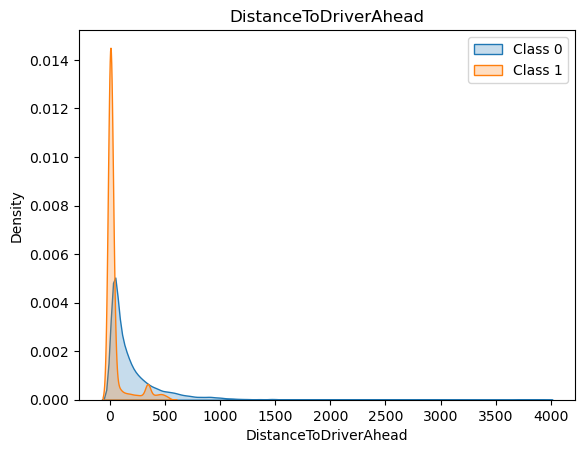

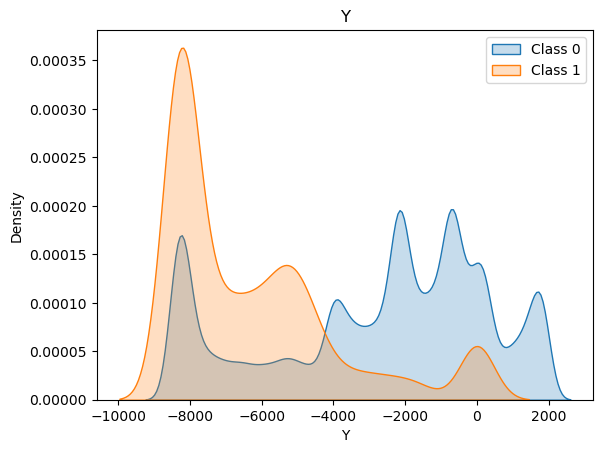

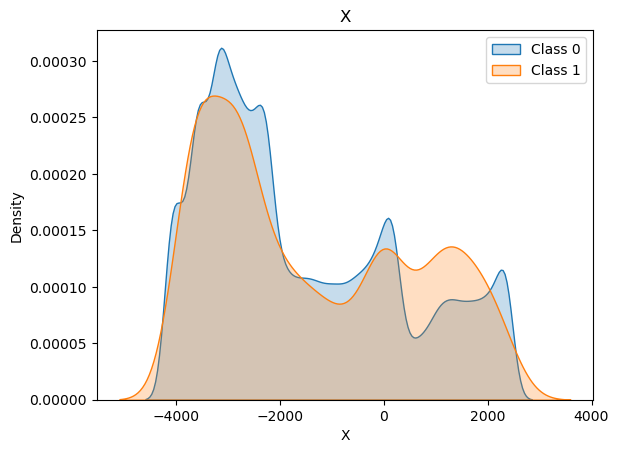

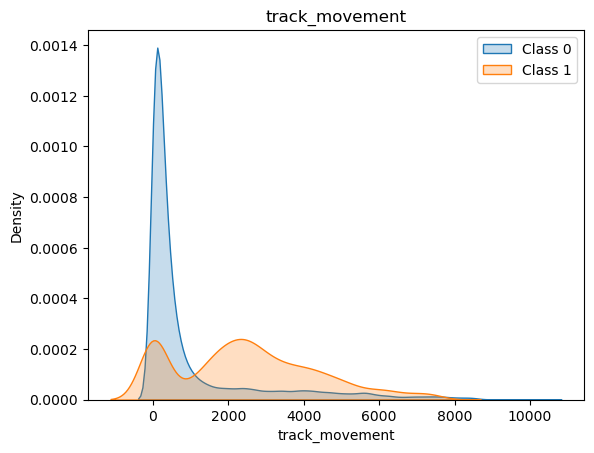

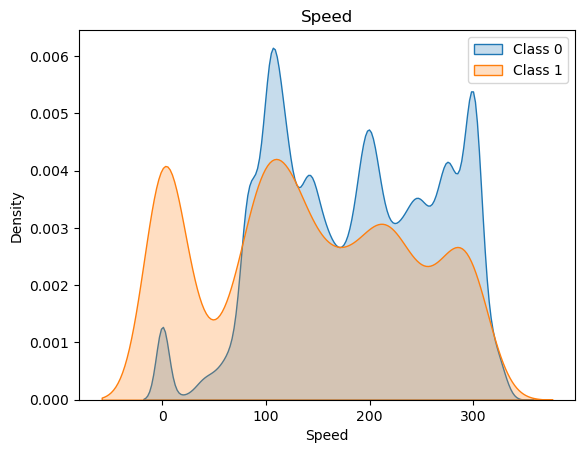

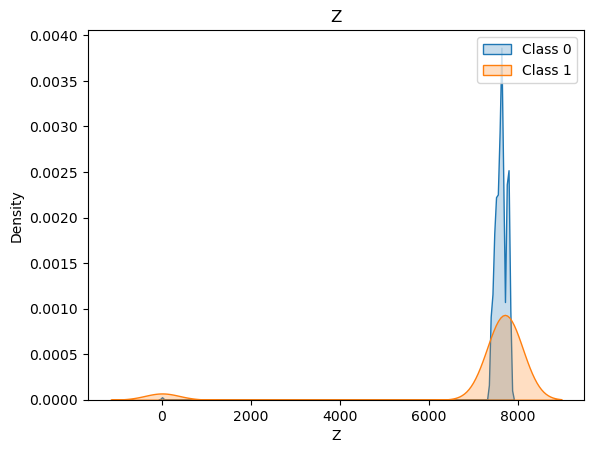

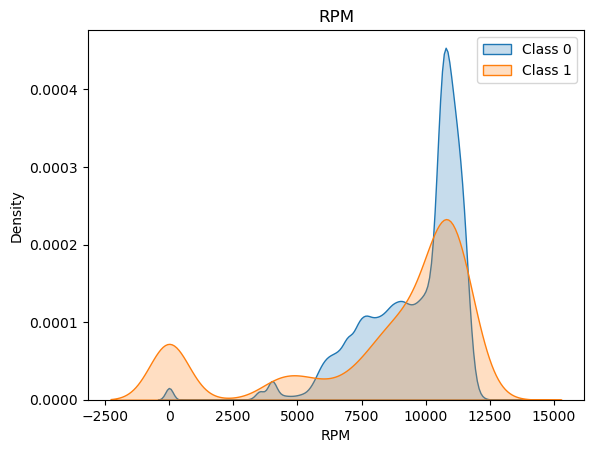

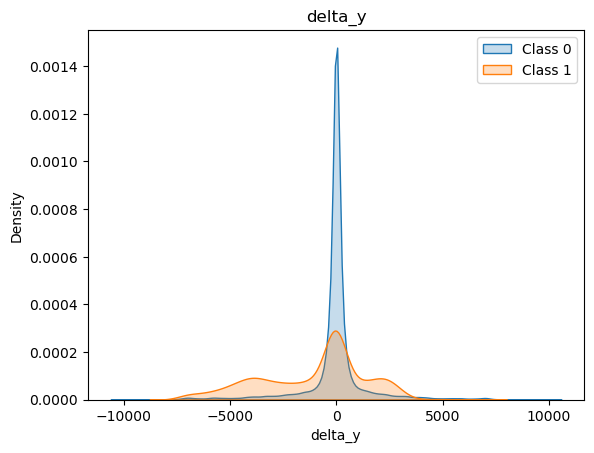

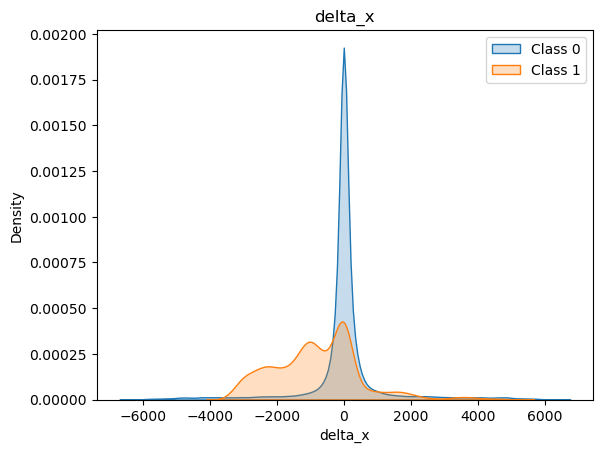

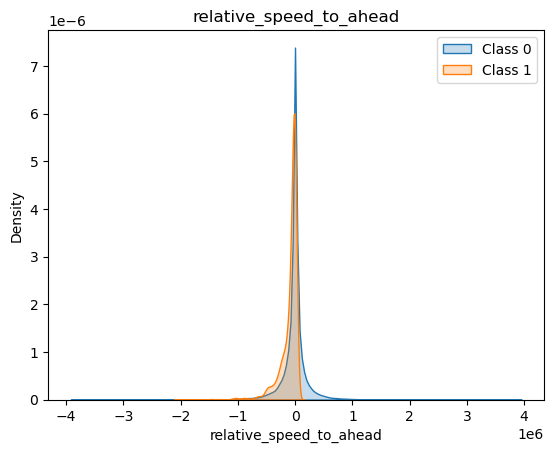

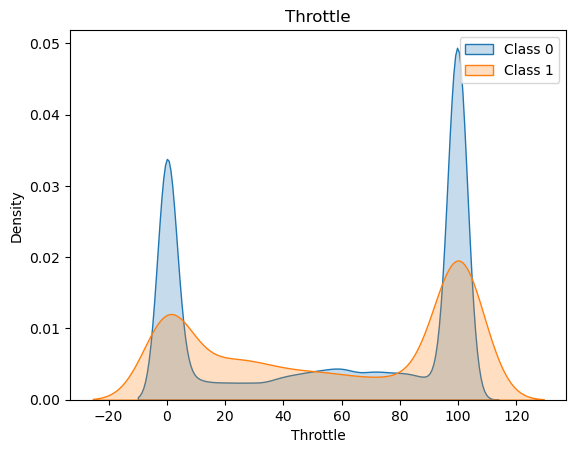

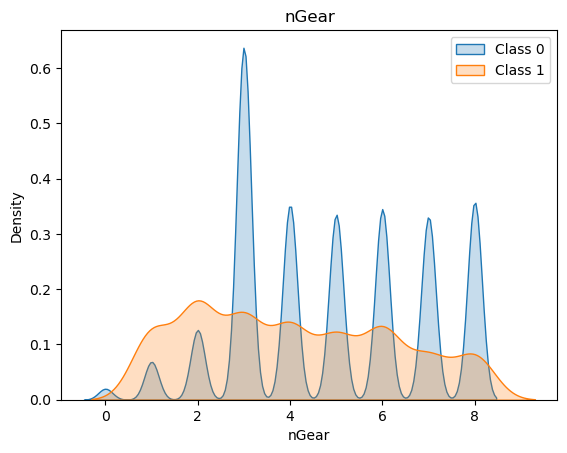

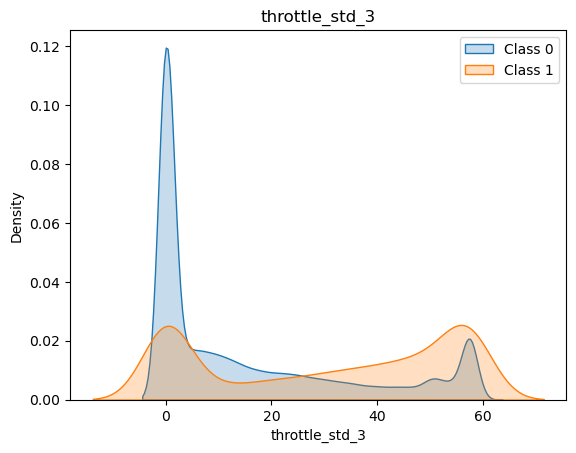

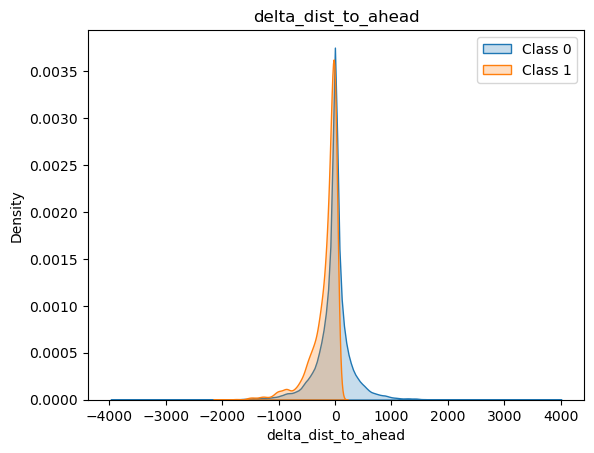

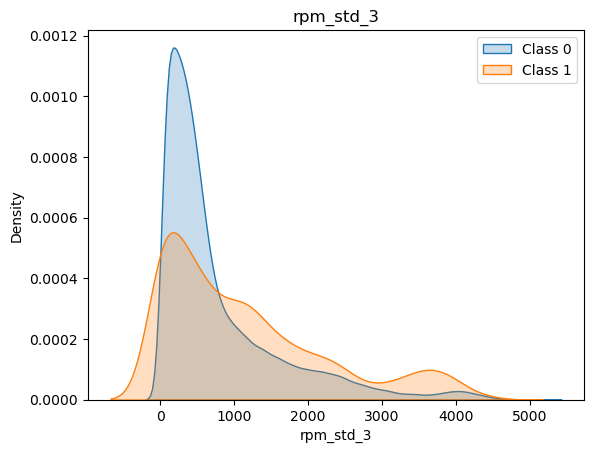

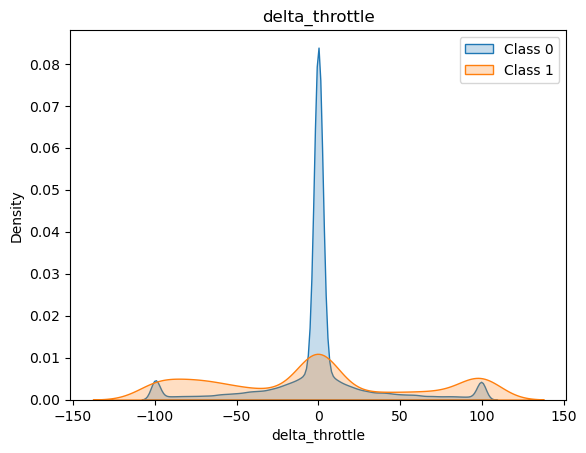

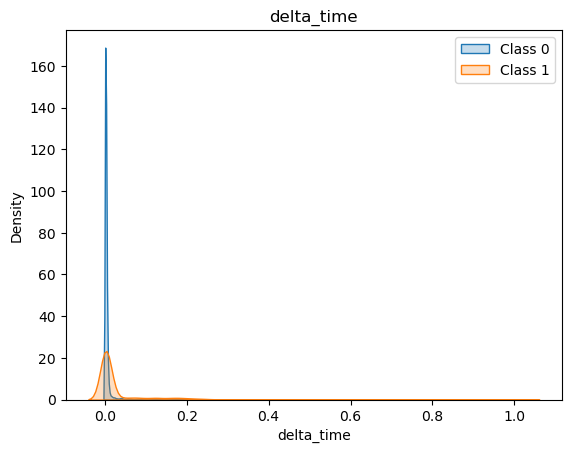

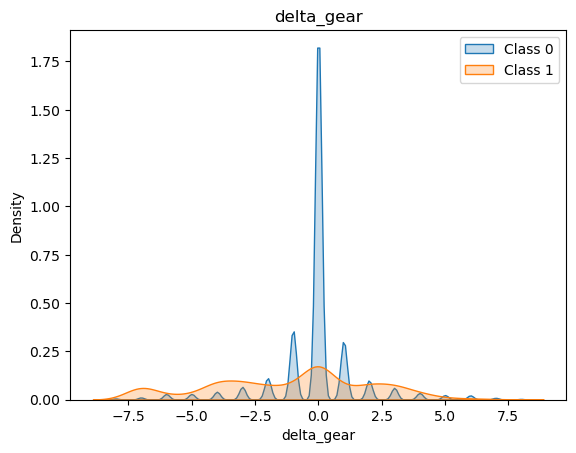

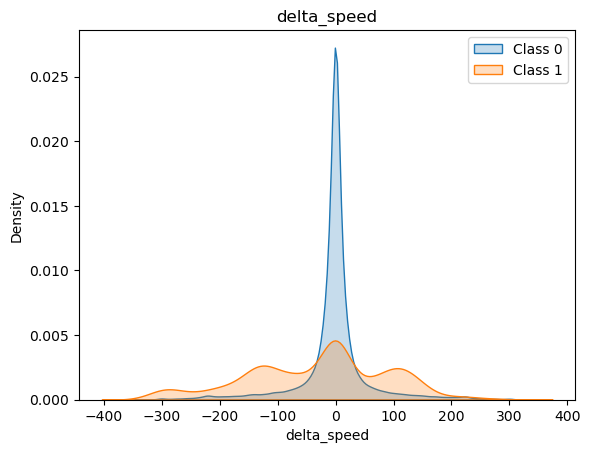

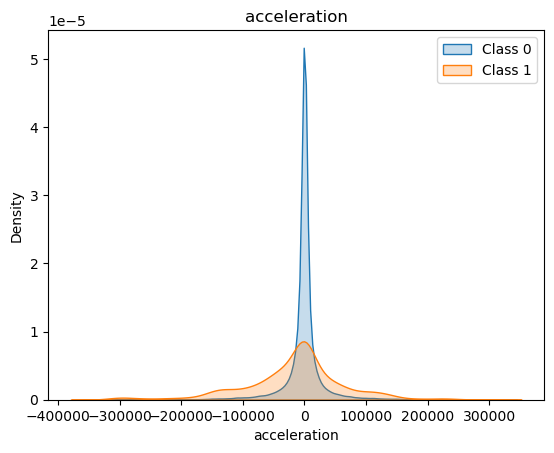

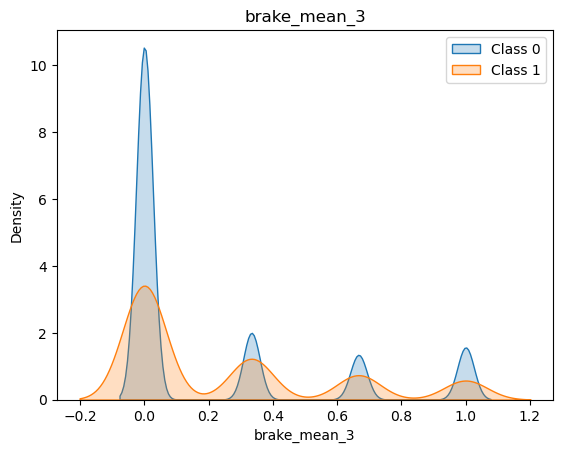

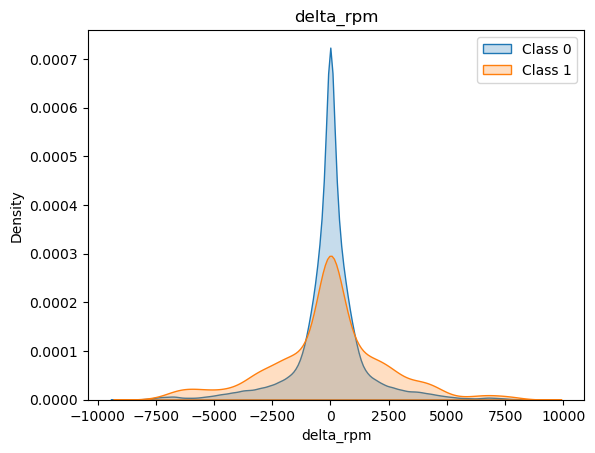

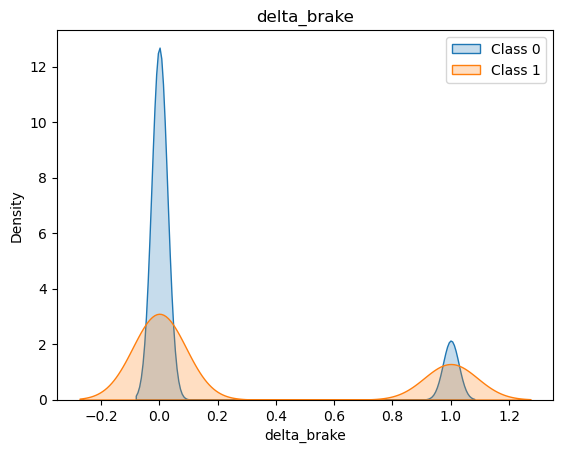

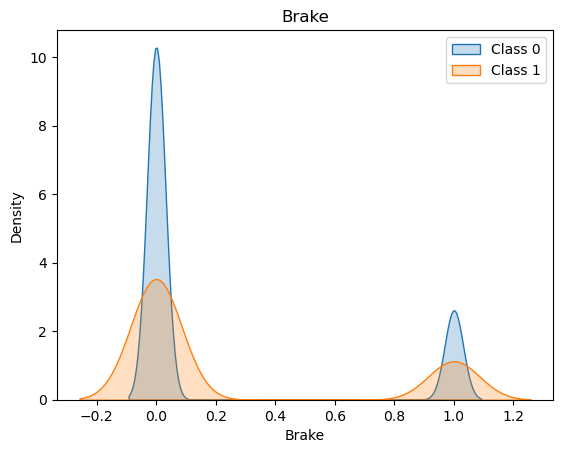

In [77]:
for idx, row in feat_imp_df.iterrows():
    sns.kdeplot(X_train[row.loc['feature']][y_train == 0], label="Class 0", fill=True)
    sns.kdeplot(X_train[row.loc['feature']][y_train == 1], label="Class 1", fill=True)
    plt.title(row.loc['feature'])
    plt.legend()
    plt.show()